# Olivetti Faces dataset

In [1]:
from google import genai
from dotenv import load_dotenv
load_dotenv() # load environment variables
import time
import os
import base64
import cv2
import numpy as np
import sys
AI_MODEL_PATH = os.path.abspath(os.path.join(os.path.curdir, os.pardir, os.pardir))
sys.path.append(AI_MODEL_PATH)
from image_preprocessing import visualize_image, encode_labels, decode_labels

## Load the Data

In [2]:
# https://www.kaggle.com/code/serkanpeldek/face-recognition-on-olivetti-dataset
olivetti_faces_data = np.load('olivetti_faces.npy')
olivetti_faces_data.shape

(400, 64, 64)

This dataset has 400 digitized images of human faces, each of 64 x 64 pixels.

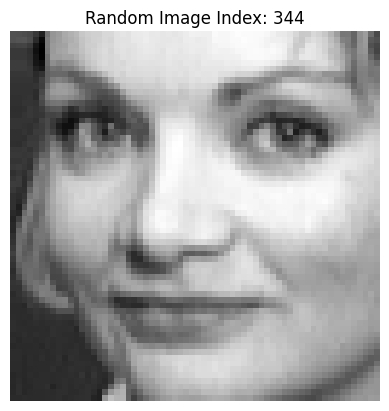

In [3]:
visualize_image(olivetti_faces_data)

In [4]:
# Google Gemini API
client = genai.Client(api_key=os.environ.get('GOOGLE_GEMINI_API_KEY'))

# Annotate an image with Google Gemini: 
# - is_human: boolean
# - emotion: string
def generate_prompt(filename: str = 'annotate-image-prompt.txt'):
    with open(filename, 'w') as file:
        file.write("Analyze the facial expression in this image.\n")
        file.write("Please provide a JSON object with the following fields:\n")
        file.write("- is_human: boolean\n")
        file.write("- emotion: string\n")
        file.write("The scope of Emotions:\n")
        file.write("1. Angry\n")
        file.write("2. Fear\n")
        file.write("3. Happy\n")
        file.write("4. Neutral\n")
        file.write("5. Sad\n")
        file.write("6. Surprise\n")
        file.write("7. Stress\n\n")
        file.write("Examples:\n")
        file.write("{\n")
        file.write("  \"is_human\": true,\n")
        file.write("  \"emotion\": \"Happy\"\n")
        file.write("}\n")
    

def annotate_images_with_gemini(images, prompt: str):
    annotations = []
    for image in images:
        # Convert the image to a format suitable for the API (e.g., base64 encoding)
        image_data = (image * 255).astype(np.uint8)  # Convert to uint8
        image_data = image_data.reshape(64, 64)  # Reshape to 64x64 if needed
        _, buffer = cv2.imencode('.jpg', image_data)
        image_base64 = base64.b64encode(buffer).decode('utf-8')

        # Prepare the payload for the Gemini API
        payload = {
            "model": "gemini-2.0-flash",
            "contents": [prompt, image_base64]
        }

        # Call the Gemini API
        response = client.models.generate_content(**payload)

        # Assuming the response object has a 'result' attribute
        if hasattr(response, 'result'):
            annotations.append(response.result)
        else:
            annotations.append({'is_human': False, 'emotion': 'Unknown'})
        
        time.sleep(5)  # Sleep for 5 seconds to avoid rate limiting

    return annotations

In [5]:
# Generate the prompt file
generate_prompt()

In [6]:
# Annotate images with Gemini
annotations: list[dict] = annotate_images_with_gemini(
    images=olivetti_faces_data, 
    prompt='annotate-image-prompt.txt'
)
IS_HUMAN_LABEL = []
EMOTION_LABEL = []

for annotation in annotations:
    IS_HUMAN_LABEL.append(annotation['is_human'] if annotation['is_human'] is not None else False)
    EMOTION_LABEL.append(annotation['emotion'] if annotation['emotion'] is not None else 'Unknown')

# Encode the labels
encoded_IS_HUMAN_labels = np.array([1 if is_human else 0 for is_human in IS_HUMAN_LABEL])
encoded_EMOTION_labels, encoder_EMOTION = encode_labels(EMOTION_LABEL)

In [7]:
assert len(IS_HUMAN_LABEL) == len(EMOTION_LABEL) == olivetti_faces_data.shape[0] == len(encoded_IS_HUMAN_labels) == len(encoded_EMOTION_labels)

In [8]:
# Save Labels to Files
LABEL_DIR = 'label'
if not os.path.exists(LABEL_DIR):
    os.makedirs(LABEL_DIR)

IS_HUMAN_LABEL_FILEPATH = os.path.join(LABEL_DIR, 'is_human_label.npy')
EMOTION_LABEL_FILEPATH = os.path.join(LABEL_DIR, 'emotion_label.npy')
np.save(IS_HUMAN_LABEL_FILEPATH, encoded_IS_HUMAN_labels)
np.save(EMOTION_LABEL_FILEPATH, encoded_EMOTION_labels)
print(f"2 Kinds of Labels are saved to {IS_HUMAN_LABEL_FILEPATH} and {EMOTION_LABEL_FILEPATH}")

2 Kinds of Labels are saved to label\is_human_label.npy and label\emotion_label.npy
